VGG16卷积网络详解
机器学习基础知识：
    1.相对熵(KL散度)：
        两个概率分布（probability distribution）间差异的非对称性度量
        衡量任意一个分布偏离真实分布的程度，如果两个分布完全匹配，那么KL散度为0，否则KL散度取值为0到无穷大之间
        https://blog.csdn.net/weixin_38026379/article/details/96114545


神经网络基础知识：
    1.卷积：
        卷积核：卷积操作中的一个过滤器，用于提取我们图像的特征
        卷积核大小：大小一般选择3x3和5x5，比较常用的是3x3
        卷积核参数：
            卷积核里面的每个值就是我们需要训练模型过程中的神经元参数（权重），开始会有随机的初始值，
            当训练网络时，网络会通过后向传播不断更新这些参数值，知道寻找到最佳的参数值。对于如何判断参数值的最佳,则是通过loss损失函数来评估.
    2.常见的卷积分为三类
        假如卷积层的输入神经元个数为M,卷积大小为K,步长为S,在输入两端各添加P个0,那么该卷积层的神经元数量为：(M-K+2p)/S+1
        1.窄卷积
            S=1,两端不补0,此时卷积后输出长度为 M-K+1
        2.宽卷积
            S=1,两端补0 P = K-1,卷积后输出长度为 M+K-1
        3.等宽卷积(常用这个)
            S=1,两端补0 P=(K-1)/2   卷积后输出长度为M

    2.常见的loss函数  ：
        最小二乘法,
        交叉熵,
        极大似然估计

    3.卷积中的padding
        作用：保持尺度不变,或者是为了利用卷积不到的边界,卷积操作之后维度变少，得到的矩阵比原来矩阵小，这样不好计算，而我们只是希望作卷积，所以我们需要Padding
        边界数值的特征提取次数相对较少，为了能更好的把边界数值也利用上，所以给原始数据矩阵的四周都补上一层0


    4.池化pooling
        作用：池化操作相当于降维操作,降低数据量和计算量
        最大池化：一般都采用最大池化,个人猜想是最大池化保留了边缘信息,关键信息
        平均池化

    5.Flatten
        作用：将高维数据拉开,降维1维数据,方便输入全连接层

    6.Dropout
        作用：可以防止模型训练过拟合的情况
        原理：训练过程中，按照一定的比例将网络中的神经元进行丢弃,模拟人的记忆遗忘特性

VGG-16 (Very Deep Convolutional Networks for Large-scale Image Recongnition)
    VGG系列有很多文章,VGG-16特指层数为16层的那一篇
    16 = 13
    论文结论
        1.在一定范围内，通过增加深度能有效地提升网络性能；
        2.最佳模型：VGG16，从头到尾只有3x3卷积与2×2池化，简洁优美；
        3.多个小卷积核比单个大卷积核性能好（与alxnet对比可知）；
        4.AlexNet曾经用到的LRN层并没有带来性能的提升，因此在其它组的网络中均没再出现LRN层；
        5.尺度抖动scale jittering（多尺度训练，多尺度测试）有利于网络性能的提升。
    VGG-16发展历史：
        LeNet - 3个卷积层 + 2个下采样 + 1个FC
        AlexNet - 5个卷积层 + 3个FC + 1个softmax
        VGG-16 - 5个卷积层 + 5个maxpool + 3FC +1个softmax

    VGG16网络结构：
     注意：描述方式采用原文的描述方式, conv(接受大小范围) - (通道数量)
     原文：denoted as “conv <receptive field size> - <number of channels>"
     input 为244x244的RGB图，所以是三个维度 244x244x3

    【input 244x244】 ->【conv（3）-（64） ，con（3）-（ 64）】->【maxpool】 3层 特征维度3->64
     ->【conv（3）-（128） ，con（3）-（128）】->【maxpool】 2层 特征维度64->128
     ->【conv（3）-（256） ，con（3）-（256），conv（3）-（256）】->【maxpool】 2层 特征维度128->256
     ->【conv（3）-（512） ，con（3）-（512），conv（3）-（512）】->【maxpool】 2层 特征维度256->512
     ->【conv（3）-（512） ，con（3）-（512），conv（3）-（512）】->【maxpool】 2层 特征维度512->512
     ->  【FC-(4096)】  ->   【FC-(4096)】  ->  【FC-(1000)】 -> 【softmax】 ->【output】 5层  特征维度 4096->1000->概率【0，1】

     总共 3+2+2+2+2+5 = 16层


注意： maxpool中 默认向下取整，maxpool不处理通道数，通道数不变
    控制参数：
    ceil_mode ：如果等于True，计算输出信号大小的时候，会使用向上取整，代替默认的向下取整的操作 maxpool默认向下取整

In [241]:
'''依据原始论文搭建VGG网络'''
import torch.nn as nn
import torch
class VGG_16(nn.Module):
    def __init__(self, num_channels=3):  #由于传入的是RGB 所以传入通道为3
        super(VGG_16, self).__init__()
        #【input 244x244】 ->【conv（3）-（64） ，con（3）-（ 64）】->【maxpool】 3层 特征维度3->64
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=(3,3), padding='same')
        self.conv2 = nn.Conv2d(64, 64, (3,3), padding='same')
        #->【conv（3）-（128） ，con（3）-（128）】->【maxpool】 2层 特征维度64->128
        self.conv3 = nn.Conv2d(64, 128, (3,3), padding='same')
        self.conv4 = nn.Conv2d(128, 128, (3,3), padding='same')
        # ->【conv（3）-（256） ，con（3）-（256），conv（3）-（256）】->【maxpool】 2层 特征维度128->256
        self.conv5 = nn.Conv2d(128,256,(3,3),padding='same')
        self.conv6 = nn.Conv2d(256,256,(3,3),padding='same')
        self.conv7 = nn.Conv2d(256,256,(3,3),padding='same')
        #->【conv（3）-（512） ，con（3）-（512），conv（3）-（512）】->【maxpool】 2层 特征维度256->512
        self.conv8 = nn.Conv2d(256,512,(3,3),padding='same')
        self.conv9 = nn.Conv2d(512,512,(3,3),padding='same')
        self.conv10 = nn.Conv2d(512,512,(3,3),padding='same')
        #->【conv（3）-（512） ，con（3）-（512），conv（3）-（512）】->【maxpool】 2层 特征维度512->512
        self.conv11 = nn.Conv2d(512,512,(3,3),padding='same')
        self.conv12 = nn.Conv2d(512,512,(3,3),padding='same')
        self.conv13 = nn.Conv2d(512,512,(3,3),padding='same')
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.linear1 = nn.Linear(in_features=512 * 7 * 7, out_features=4096)
        self.linear2 = nn.Linear(in_features = 4096,out_features=4096)
        self.dropout = nn.Dropout(p=0.5)
        self.linear3 = nn.Linear(in_features=4096,out_features=1000)
        self.sofmax = nn.Softmax()

    def forward(self,input):  # input 为 RGB 图片，此时我们关注一下图片的大小
        temp  = self.relu(self.conv1(input)) #244x244
        temp  = self.relu(self.conv2(temp))
        temp  = self.maxpool(temp) # (M-K+2p)/S+1  （244-2）/2+1 =122  此时图片大小 122x122
        temp  = self.relu(self.conv3(temp))
        temp  = self.relu(self.conv4(temp))
        temp  = self.maxpool(temp)#  （122-2）/2+1 = 61  61x61
        temp  = self.relu(self.conv5(temp))
        temp  = self.relu(self.conv6(temp))
        temp  = self.relu(self.conv7(temp))
        temp  = self.maxpool(temp)#  向下取整（61-2）/2+1 =  30x30
        temp  = self.relu(self.conv8(temp))
        temp  = self.relu(self.conv9(temp))
        temp  = self.relu(self.conv10(temp))
        temp  = self.maxpool(temp) # （30-2）/2 +1 = 15  15x15
        temp  = self.relu(self.conv11(temp))
        temp  = self.relu(self.conv12(temp))
        temp  = self.relu(self.conv13(temp))
        temp  = self.maxpool(temp)# （15-2）/2+1 = 7x7
        # torch.Size([1, 512, 7, 7])
        temp = temp.reshape(-1)  # 一维  25088
        temp = self.relu(self.linear1(temp))
        temp = self.dropout(temp)
        temp = self.relu(self.linear2(temp))
        temp = self.dropout(temp)
        temp = self.linear3(temp)
        temp = self.sofmax(temp)
        return temp

图像的上采样和下采样
opencv中给了好几种，这里介绍两种
    1.高斯金字塔：同一图像不同分辨律的子图集合
        下采样：
            1.对图像IMG进行高斯卷积。
            2.删除所有行和列。
        上采样：
            1.行和列扩展为原来的两倍，用0填充。
            2.使用和向下采样同样的高斯核，并将其乘以m，对图像进行卷积。
    2.resize  （src，source）
        1.最近邻插值    -INTER_NEAREST；
        2.线性插值      -INTER_LINEAR；（默认值）
        3.区域插值      -INTER_AREA；(利用像素区域关系的重采样插值)
        4.三次样条插值   -INTER_CUBIC（超过4*4像素邻域内的双三次插值）
        5.Lanczos插值  -INTER_LANCZOS4

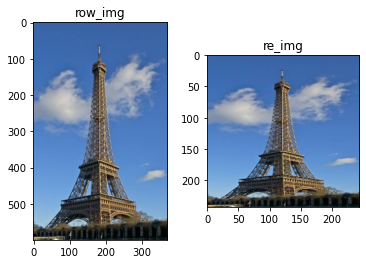

In [242]:
'''生成一个VGG16 需要的图片数据'''
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread('Pyramid.jpg') #此图片为 H x W x C 600x370x3 ，读入通道为BGR
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
'''图像金字塔,高斯金字塔,按比例上升，缩放'''
# img_down = cv2.pyrDown()
# print(img_down.shape) # 300,185,3
'''图像指定大小 resize 函数  cv2.resize(image,None,fx=int or float,fy=int or float)'''
re_img = cv2.resize(img,(244,244))
re_img1 = cv2.cvtColor(re_img,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title('row_img')
plt.imshow(img1)
plt.subplot(1,2,2)
plt.title('re_img')
plt.imshow(re_img1)
plt.show()

由于conv2d需要一个指定格式的数据
batch_size ,然后为通道数,然后才是图片的高和宽
故而需要处理图片的数据格式
由于只传入1张图片，所以batch——size = 1

In [243]:
'''数据格式处理'''
IMG  =  np.zeros((1,3,244,244))
R,G,B = re_img1[:,:,0],re_img1[:, :,1 ],re_img1[:, :,2 ]
IMG[:,0,:,:],IMG[:,1,:,:],IMG[:,2,:,:] = R,G,B
IMG = torch.tensor(IMG)
IMG = IMG.to(torch.float32)
IMG.shape,type(IMG[0,0,0,0])

(torch.Size([1, 3, 244, 244]), torch.Tensor)

In [244]:
'''测试VGG16网络'''
vgg16 = VGG_16(num_channels=3)
out = vgg16.forward(input=IMG)
print(out.shape) #torch.Size([1000])

torch.Size([1000])


E:\anaconda\envs\notebook\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


至此，完成了对VGG16的完成和实验

写代码中遇到的问题


报错 RuntimeError: expected scalar type Double but found Float
解决办法，IMG的元数据类型改为tensor.float32

报错 RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x7 and 25088x4096)
    推测是在Linear模块 3587 = 512x7   x7
    原因解析 linear模块只会将最后维度 升维度或者降低，此时传入为【1x512x7x7】，没有拉平成【25088】
    加入代码 temp.reshape(-1)先降维到1维度拉平 再调用Linear 模块

报错 TypeError: forward() missing 1 required positional argument: 'input'
    探明原因是在dropout 需要传入参数
    temp = self.dropout(temp) 其调用方法和conv ，maxpool一样

警告 UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp = self.sofmax(temp)
  原因：原因是softmax（）函数已经被弃用了，虽然程序还是可以运行成功，但是这个做法不被pytorch所赞成。这个写法在早期的pytorch版本是没有警告的，现在因为其他考虑，要加上有指明dim参数
  解决办法：
    nn.Softmax() 目前需要加维度改成   nn.Softmax(dim=1)